# Creating Train/Test Split Using Web Data
In this notebook we attempt to split listings into train and test on an individual user basis

We will train our models using the first 70% of listings that a user saw during the year, and will test the models to see if they are able to predict the rest (30%) of listings each user saw at the end of the year.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

### Read in filtered webdata 
(from `Load_Web_Data.ipynb`) 

In [ ]:
df = pd.read_pickle("all_webdata_filtered.pkl")
df.rename({'rexurl':'rexUrl'},axis=1,inplace=True)
df_web_la = df.copy()

print('total LA web interactions',df_web_la.shape)

total LA web interactions (4617883, 6)


In [ ]:
# Convert eventstamp to datetime
df_web_la['event_stamp'] = pd.to_datetime(df_web_la['event_stamp'])

#sort by user and eventstamp within each user
df_web_la.sort_values(['ip','event_stamp'],ascending=True,inplace=True)

## Temporal Train/Test Split

In [ ]:
# pull out unique ip, rexUrl pairings
ip_listing = df_web_la[['ip','rexUrl']].drop_duplicates().reset_index(drop=True)

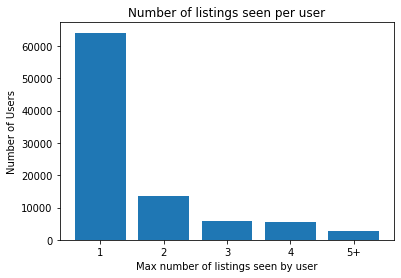

In [ ]:
# Visualize the number of listings seen by each user
plt.bar(x=['1','2','3','4','5+'], height=pd.Series(np.clip(ip_listing.groupby('ip')['rexUrl'].count().values,0,5)).value_counts())
plt.title('Number of listings seen per user')
plt.xlabel('Max number of listings seen by user')
plt.ylabel('Number of Users')
plt.show()

In [ ]:
# Figure out a reasonable train/test cut split that would work on a user-basis
for i in range(11):
  trainex = list(range(0,int(np.ceil(i*0.7))))
  testex = list(range(int(np.ceil(i*0.7)),i))
  percent=0
  if len(testex)!=0:
    percent = np.round(100*len(testex)/(len(trainex)+len(testex)),2)
  print(f'see {i} listing, split', trainex ,  testex, ' | Test %',percent)

see 0 listing, split [] []  | Test % 0
see 1 listing, split [0] []  | Test % 0
see 2 listing, split [0, 1] []  | Test % 0
see 3 listing, split [0, 1, 2] []  | Test % 0
see 4 listing, split [0, 1, 2] [3]  | Test % 25.0
see 5 listing, split [0, 1, 2, 3] [4]  | Test % 20.0
see 6 listing, split [0, 1, 2, 3, 4] [5]  | Test % 16.67
see 7 listing, split [0, 1, 2, 3, 4] [5, 6]  | Test % 28.57
see 8 listing, split [0, 1, 2, 3, 4, 5] [6, 7]  | Test % 25.0
see 9 listing, split [0, 1, 2, 3, 4, 5, 6] [7, 8]  | Test % 22.22
see 10 listing, split [0, 1, 2, 3, 4, 5, 6] [7, 8, 9]  | Test % 30.0


Generate Train/Test Split Dictionaries and DF

In [ ]:
# Generate Dictionaries for train and test
train_g = ip_listing.groupby('ip')['rexUrl'].apply(lambda x: list(x[0:int(np.ceil(len(x)*0.7))]))
test_g = ip_listing.groupby('ip')['rexUrl'].apply(lambda x: list(x[int(np.ceil(len(x)*0.7)):]))

In [ ]:
# Convert dictionaries to df
test_la = pd.DataFrame(test_g).reset_index().explode('rexUrl')
test_la.dropna(inplace=True)
train_la = pd.DataFrame(train_g).reset_index().explode('rexUrl')

#subset train to only include users that appear in test
train_la = train_la[train_la.ip.isin(set(test_la.ip))].copy()

In [ ]:
# gut check that the train/test split is working correctly
testip='99.203.75.183'
print('All Listings User Saw')
display(df_web_la[df_web_la.ip==testip].drop_duplicates(['ip','rexUrl'])[['ip','rexUrl']])
print('\n Temporal Split Train Set')
display(train_la[train_la.ip==testip])
print('\n Temporal Split Test Set')
display(test_la[test_la.ip==testip])

All Listings User Saw


,ip,rexUrl
5072094,99.203.75.183,22718-figueroa-st-unit-21
5072097,99.203.75.183,1509-inverness-dr
5072104,99.203.75.183,6954-rubio-ave
5072212,99.203.75.183,16321-janine-dr
5072276,99.203.75.183,9323-alcott-st-apt-101
5072281,99.203.75.183,1415-n-myers-st



 Temporal Split Train Set


,ip,rexUrl
90558,99.203.75.183,22718-figueroa-st-unit-21
90558,99.203.75.183,1509-inverness-dr
90558,99.203.75.183,6954-rubio-ave
90558,99.203.75.183,16321-janine-dr
90558,99.203.75.183,9323-alcott-st-apt-101



 Temporal Split Test Set


,ip,rexUrl
90558,99.203.75.183,1415-n-myers-st


In [ ]:
# Shape Checks
print(train_la.shape)
print(test_la.shape)
print(test_la.shape[0]/(test_la.shape[0]+train_la.shape[0]))

# There is no IP in test that isnt in train
print(set(train_la.ip) - set(test_la.ip))

# There is no IP in train that isnt in test
print(set(test_la.ip) - set(train_la.ip))

# Number of unique users in train/test sets
print(train_la.ip.nunique())
print(test_la.ip.nunique())

(51060, 2)
(17102, 2)
0.25090226225756285
set()
set()
8663
8663


### Visualize Train/Test sizes per user

In [ ]:
# Loop through each user and pull out the size of their train set and test set
train_test_count = {}
for i in test_g.keys():
  trainsize = len(train_g[i])
  testsize = len(test_g[i])
  train_test_count[i] = [trainsize, testsize]

train_test_count_df = pd.DataFrame.from_dict(train_test_count,orient='index')
train_test_count_df.rename({0:'trainsize',1:'testsize'},axis=1,inplace=True)

In [ ]:
train_test_count_df.head()

,trainsize,testsize
1.0.84.114,1,0
1.125.109.121,1,0
1.125.110.139,1,0
1.128.106.121,2,0
1.128.106.169,1,0


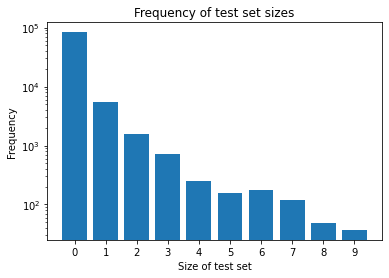

In [ ]:
# visualize sizes of users' test sets
test_set_sizes = train_test_count_df.testsize.value_counts().head(10)
plt.bar(x=test_set_sizes.index, height=test_set_sizes)
plt.xticks(test_set_sizes.index)
plt.yscale('log')
plt.title('Frequency of test set sizes')
plt.xlabel('Size of test set')
plt.ylabel('Frequency')
plt.show()

## Saving Temporal Train/Test Datasets of User-Listing Views

In [ ]:
train_la.to_pickle('ip_listing_temporal_train_full.pkl')
test_la.to_pickle('ip_listing_temporal_test_full.pkl')